In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from itertools import product
from tqdm import tqdm

from device_definition import device_definition,  plotting_device_resonances, plotting_device_resonances_iter
from simplified_sequential_assignment import optimal_sequential_assignment, device_resonances_heated_func
from simplified_mrm_crr_cycling import mrm_cycling_func, crr_locking_func
from copy import deepcopy

## MRM and CRR resonance definition

In [2]:
tx_bank, rx_bank, laser = device_definition(no_iterations=int(1e3+1), centroid_die_variation_bool=False, laser_distribution_uniform=False, die_variation_uniform_bool=False)

mrm_resonances_die_wafer_variation = tx_bank["mrm_resonances_die_wafer_variation"]
crr_resonances_die_wafer_variation = rx_bank["crr_resonances_die_wafer_variation"]
ideal_resonance = tx_bank["ideal_resonances"]
laser_frequency = laser["laser_frequency"]

step_sweep = 200

no_mrm_cycling_steps = 4
no_crr_cycling_steps = 6

no_mrm_internal_alignment_steps = 20
no_crr_internal_alignment_steps = 20

debug = 0

bins = 101

## Plotting MRM and CRR resonances

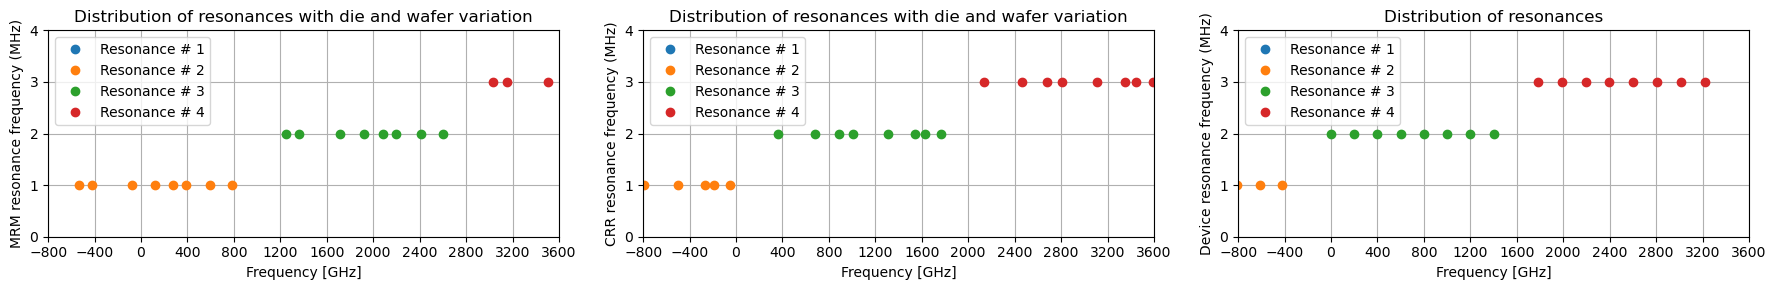

In [3]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

## Sequential Assignment of MRM

In [4]:
mrm_lock_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 7, mrm_resonances_die_wafer_variation.shape[2]))
mrm_sequential_success_metric = []
iter_satisfaction = []

mrm_laser_assigned = []
mrm_sequential_assigned = []

for iter_no in tqdm(range(mrm_resonances_die_wafer_variation.shape[2])):
  mrm_resonances_iter = mrm_resonances_die_wafer_variation[:, :, iter_no]
  if debug:
    print("\n")
    print("Iteration number", iter_no)
  device_dict = optimal_sequential_assignment(mrm_resonances_iter, laser_frequency, device_optical_bandwidth = tx_bank["mrm_optical_bandwidth"], step_sweep = 200, debug = debug, optimization_bool=True)
  heat_assigned = device_dict["heat_assigned"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"]) * np.ones(mrm_resonances_iter.shape[0]) * step_sweep
  heat_applied = device_dict["heat_applied"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"])  * np.ones(mrm_resonances_iter.shape[0]) * step_sweep
    
  optimized_heat = deepcopy(heat_assigned)
  mrm_lock_data[:, 0, iter_no] = device_dict["device_assigned"]
  mrm_lock_data[:, 1, iter_no] = device_dict["laser_assigned"]
  mrm_lock_data[:, 2, iter_no] = heat_assigned
  mrm_lock_data[:, 3, iter_no] = heat_applied
  mrm_lock_data[:, 4, iter_no] = device_dict["resonance_assigned"]
  mrm_lock_data[:, 5, iter_no] = device_dict["heat_cycling"]
  mrm_lock_data[:, 6, iter_no] = device_dict["cool_cycling"]
  
  if len(np.unique(device_dict["laser_assigned"])) == 8:
    mrm_sequential_success_metric.append(iter_no)

print("Successful sequential alignment of MRM to laser wavelengths", len(mrm_sequential_success_metric)/mrm_resonances_die_wafer_variation.shape[2]*100, "%")


100%|██████████| 1001/1001 [00:00<00:00, 7769.08it/s]

Successful sequential alignment of MRM to laser wavelengths 100.0 %


/var/folders/gl/2rnst3qn1ybbrqznnrfypxkw0000gn/T/ipykernel_20640/562680746.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


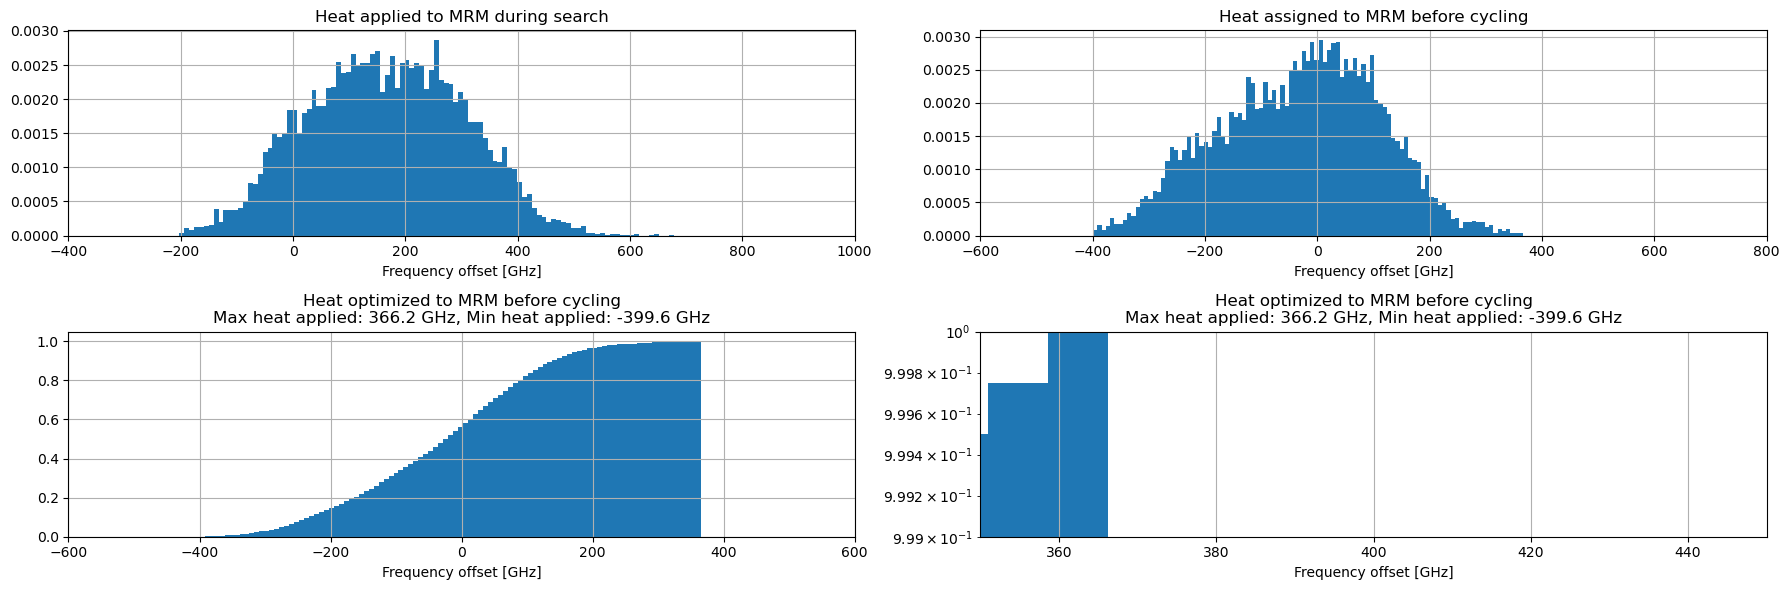

In [5]:
plt.figure(figsize=(18,6))
plt.subplot(221)
plt.hist(mrm_lock_data[:, 3, :].flatten(), density=True, bins=bins)
plt.xlim([-400, 1000])
plt.grid()
plt.title("Heat applied to MRM during search")
plt.xlabel("Frequency offset [GHz]")
plt.subplot(222)
plt.hist(mrm_lock_data[:, 2, :].flatten(), density=True,  bins=bins)
plt.xlim([-600, 800])
plt.title("Heat assigned to MRM before cycling")
plt.xlabel("Frequency offset [GHz]")
plt.grid()
plt.subplot(223)
plt.hist(mrm_lock_data[:, 2, :].flatten(), cumulative=True, density=True,  bins=bins)
plt.xlim([-600, 600])
plt.title("Heat optimized to MRM before cycling\n"+f"Max heat applied: {np.max(mrm_lock_data[:, 2, :]):0.1f} GHz, "+f"Min heat applied: {np.min(mrm_lock_data[:, 2, :]):0.1f} GHz")
plt.xlabel("Frequency offset [GHz]")
plt.grid()
plt.tight_layout()
plt.subplot(224)
plt.hist(mrm_lock_data[:, 2, :].flatten(), cumulative=True, density=True,  bins=bins)
plt.yscale("log")
plt.ylim(0.999, 1.0)
plt.xlim([350, 450])
plt.title("Heat optimized to MRM before cycling\n"+f"Max heat applied: {np.max(mrm_lock_data[:, 2, :]):0.1f} GHz, "+f"Min heat applied: {np.min(mrm_lock_data[:, 2, :]):0.1f} GHz")
plt.xlabel("Frequency offset [GHz]")
plt.grid()
plt.tight_layout()
plt.show()


In [6]:
for iter_no in range(mrm_resonances_die_wafer_variation.shape[2]):
    if np.min(mrm_lock_data[:, 2, iter_no]) < 000:
        print("Iteration number", iter_no)
        print("MRM sequence:", mrm_lock_data[:, 0, iter_no])
        print("Laser assigned:", mrm_lock_data[:, 1, iter_no])
        print("Heat assigned:", mrm_lock_data[:, 2, iter_no])
        print("Heat applied:", mrm_lock_data[:, 3, iter_no])
        print("Resonance assigned:", mrm_lock_data[:, 4, iter_no])
        print("Heat cycling:", mrm_lock_data[:, 5, iter_no])
        print("Cool cycling:", mrm_lock_data[:, 6, iter_no])
        break

Iteration number 0
MRM sequence: [7. 6. 5. 4. 3. 2. 1. 0.]
Laser assigned: [2. 6. 1. 5. 0. 4. 3. 7.]
Heat assigned: [  19.30951268   -9.67448739   15.96240915  -80.45579837 -123.11743313
 -116.55622654 -164.44302479 -229.71442229]
Heat applied: [ 19.30951268 206.32551261 205.96240915 123.54420163  78.88256687
  75.44377346 235.55697521 -49.71442229]
Resonance assigned: [2. 3. 2. 3. 2. 3. 3. 4.]
Heat cycling: [0. 0. 0. 0. 0. 0. 0. 0.]
Cool cycling: [0. 0. 0. 0. 0. 0. 0. 0.]


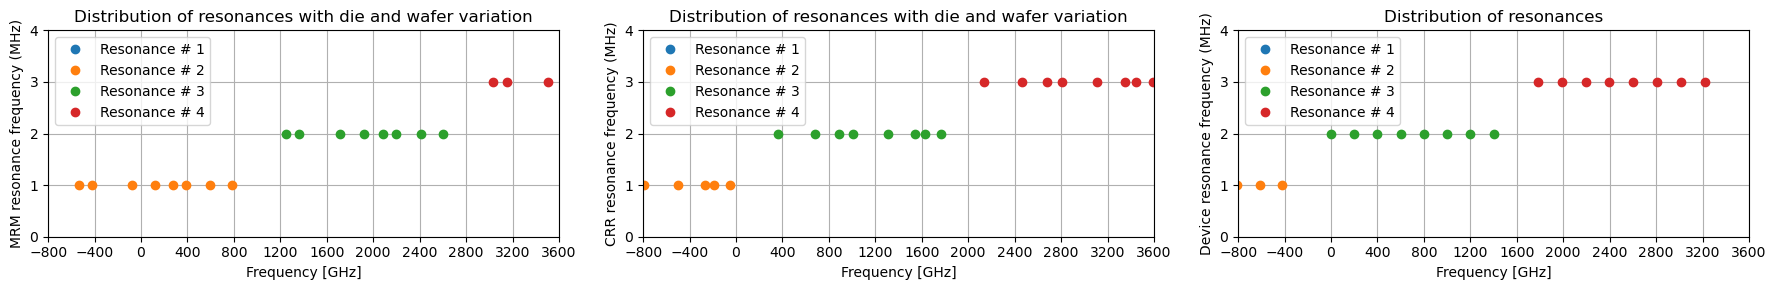

In [7]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance, idd_iter = iter_no)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

## Barrel-roll cycling of MRMs

In [8]:
no_mrm_cycling_steps = 4
cycled_mrm_lock_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 7*no_mrm_cycling_steps, mrm_resonances_die_wafer_variation.shape[2]))
iter_no = 0


cycled_mrm_sequential_success_metric = []
for iter_no in tqdm(range(mrm_resonances_die_wafer_variation.shape[2])):
    for mrm_cycling_no in range(no_mrm_cycling_steps):
        mrm_heat_cycling = mrm_lock_data[0, 5, iter_no]
        total_mrm_heat_cycling = mrm_cycling_no + mrm_heat_cycling
        mrm_heat_assigned = mrm_lock_data[:, 2, iter_no]

        cycled_mrm_dict = mrm_cycling_func(mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], mrm_heat_assigned, total_mrm_heat_cycling, step_sweep = step_sweep, debug = 0)
        
        if len(np.unique(cycled_mrm_dict["cycled_mrm_laser_assigned"])) == 8:
            cycled_mrm_sequential_success_metric.append(iter_no)
            break

print("Successful sequential alignment of MRM to laser wavelengths", len(cycled_mrm_sequential_success_metric*no_mrm_cycling_steps)/mrm_resonances_die_wafer_variation.shape[2]/no_mrm_cycling_steps*100, "%")


100%|██████████| 1001/1001 [00:00<00:00, 6139.40it/s]

Successful sequential alignment of MRM to laser wavelengths 100.0 %


In [9]:
cycled_mrm_dict["cycled_mrm_laser_assigned"]

array([4, 3, 7, 2, 6, 1, 5, 0])

In [10]:
mrm_lock_data[:, 1, iter_no]

array([4., 3., 7., 2., 6., 1., 5., 0.])